In [18]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as datetime

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

from mpl_toolkits.axes_grid1 import make_axes_locatable


# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

In [161]:
# Full 3d-ray loader:
ray_dir = '/shared/users/asousa/WIPP/rays/ngo_dipole/'
from raytracer_utils import read_rayfile, read_damp
from scipy.spatial import Delaunay

flash_lat = 40
flash_lon = 76

max_dist = 500 #km


d = os.listdir(ray_dir)
freqs = sorted([int(f[2:]) for f in d if f.startswith('f_')])
d = os.listdir(os.path.join(ray_dir, 'f_%d'%freqs[0]))
lons = sorted([int(f[4:]) for f in d if f.startswith('lon_')])
d = os.listdir(os.path.join(ray_dir, 'f_%d'%freqs[0], 'lon_%d'%lons[0]))
lats = sorted([int(s.split('_')[2]) for s in d if s.startswith('ray_')])


latgrid, longrid = np.meshgrid(lats,lons)
latln_pairs = zip(latgrid.ravel(), longrid.ravel())

pairs_in_range = []

for coords in latln_pairs:
    cur_d = haversine_np(flash_lon, flash_lat, coords[1], coords[0])
    if cur_d < max_dist:
        pairs_in_range.append(coords)

tmax = 10
dt   = 0.1
t = np.arange(0,tmax, dt)
        
# Load vectors and interpolate:
# freqs = [200, 230]

ray_data = dict()
for coords in pairs_in_range:
    for freq in freqs:
        lat = coords[0]
        lon = coords[1]
        filename = os.path.join(ray_dir,'f_%d'%freq,'lon_%d'%lon,'ray_%d_%d_%d.ray'%(freq,lat,lon))
        rf = read_rayfile(filename)[0]
        filename = os.path.join(ray_dir,'f_%d'%freq,'lon_%d'%lon,'damp_%d_%d_%d.ray'%(freq,lat,lon))
        df = read_damp(filename)[0]
        
        t_cur = t[t <= rf['time'].iloc[-1]]

        # Interpolate onto our new time axis:
        x = interpolate.interp1d(rf['time'],rf['pos']['x']).__call__(t_cur)/R_E
        y = interpolate.interp1d(rf['time'],rf['pos']['y']).__call__(t_cur)/R_E
        z = interpolate.interp1d(rf['time'],rf['pos']['z']).__call__(t_cur)/R_E
        d = interpolate.interp1d(df['time'],df['damping']).__call__(t_cur)

        # Stash it somewhere:
        key = (freq, lat, lon)
        curdata = dict()
        curdata['pos'] = np.vstack([x,y,z])
        curdata['damp']= d
        ray_data[key] = curdata

print np.shape(ray_data[ray_data.keys()[0]]['pos'])

# Find adjacent triangles, calculate total power:


(3, 100)


In [515]:
# 2d ray loader (rotate and clone to get longitudes):
# Full 3d-ray loader:
ray_dir = '/shared/users/asousa/WIPP/rays/2d/ngo_dipole/'
from raytracer_utils import read_rayfile, read_damp
from scipy.spatial import Delaunay
from scipy import stats

flash_lat = 40
flash_lon = 76

max_dist = 1500 #km
tmax = 10
dt   = 0.1
t = np.arange(0,tmax, dt)
        

d = os.listdir(ray_dir)
freqs = sorted([int(f[2:]) for f in d if f.startswith('f_')])
d = os.listdir(os.path.join(ray_dir, 'f_%d'%freqs[0]))
lons = sorted([float(f[4:]) for f in d if f.startswith('lon_')])
d = os.listdir(os.path.join(ray_dir, 'f_%d'%freqs[0], 'lon_%d'%lons[0]))
lats = sorted([float(s.split('_')[2]) for s in d if s.startswith('ray_')])

# Closest available longitude to the flash:
center_lon = lons[np.argmin(np.abs(np.array(lons) - flash_lon))]
center_lat = lats[np.argmin(np.abs(np.array(lats) - flash_lat))]


# Latitude spacing:
# dl = stats.mode(np.diff(lats))[0][0]
dl = 1

newlons = np.arange(center_lon - 2*np.round(max_dist/111.0), center_lon + 2*np.round(max_dist/111.0) + dl, dl, dtype=float)
latgrid, longrid = np.meshgrid(lats,newlons)
latln_pairs = zip(latgrid.ravel(), longrid.ravel())

pairs_in_range = []

# Select points within range.
# Prune out some points the further out we go:
for coords in latln_pairs:
    if coords[0]%1==0:
        cur_d = haversine_np(flash_lon, flash_lat, coords[1], coords[0])
        if cur_d < max_dist:

            if (cur_d < 300):
                pairs_in_range.append(coords)
            elif (cur_d < 600 and (center_lat - coords[0])%2==1 and (center_lon - coords[1])%2==1):
                pairs_in_range.append(coords)
            elif (cur_d < 1200 and (center_lat - coords[0])%4==1 and (center_lon - coords[1])%4==1):                
                pairs_in_range.append(coords)
            elif (cur_d < 2000 and (center_lat - coords[0])%8==1 and (center_lon - coords[1])%8==1):                
                pairs_in_range.append(coords)


# print pairs_in_range
    
        
# Load and interpolate the center longitude entries:
ray_data = dict()
for freq in freqs:
    for lat in np.unique([x[0] for x in pairs_in_range]):
        lon = center_lon
        filename = os.path.join(ray_dir,'f_%d'%freq,'lon_%d'%lon,'ray_%d_%d_%d.ray'%(freq,lat,lon))
#         print filename
        rf = read_rayfile(filename)[0]
        
        filename = os.path.join(ray_dir,'f_%d'%freq,'lon_%d'%lon,'damp_%d_%d_%d.ray'%(freq,lat,lon))
        df = read_damp(filename)[0]
        
        t_cur = t[t <= rf['time'].iloc[-1]]
        
        # Interpolate onto our new time axis:
        x = interpolate.interp1d(rf['time'],rf['pos']['x']).__call__(t_cur)/R_E
        y = interpolate.interp1d(rf['time'],rf['pos']['y']).__call__(t_cur)/R_E
        z = interpolate.interp1d(rf['time'],rf['pos']['z']).__call__(t_cur)/R_E
        d = interpolate.interp1d(df['time'],df['damping']).__call__(t_cur)

        # Stash it somewhere:
        key = (freq, lat, lon)
        curdata = dict()
        curdata['pos'] = np.vstack([x,y,z])
        curdata['damp']= d
        curdata['nt'] = len(t_cur)
        ray_data[key] = curdata
#         dlon = lon - center_lon
#         newpos = rotate_latlon(curdata['pos'],itime)
        

size of adj_inds: (144, 3)
31.0 47.0


<IPython.core.display.Javascript object>


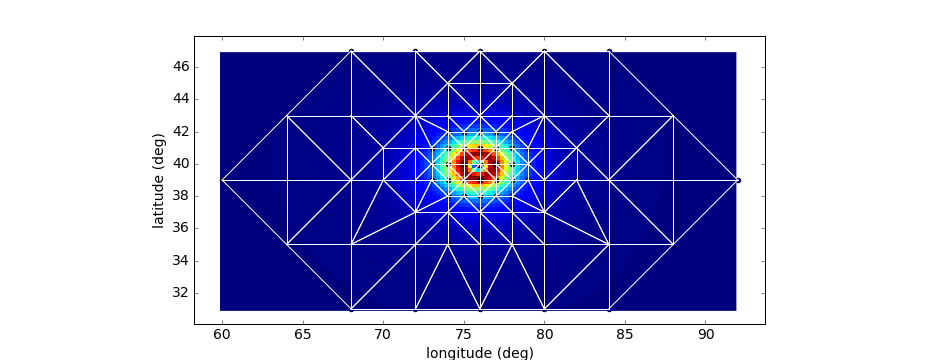

total energy:  2854.03412852 J


In [529]:
from scipy.spatial import Delaunay
from graf_iono_absorp import total_input_power, MLT, input_power_scaling
import xflib
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')


# Get adjacent triangles:
tris = Delaunay(pairs_in_range)
adj_inds = np.array(tris.simplices)
starting_coords = np.array(pairs_in_range)

print "size of adj_inds:",np.shape(adj_inds)
Hz2Rad = 2.*np.pi
D2R = np.pi/180.
H_IONO = 1e5
R_E = 6371e3

# Loop through frequency pairs:
f1 = 3920
f2 = 4580

itime = datetime.datetime(2010,1,1,0,0,0)
I0 = -10000

print min(starting_coords[:,0]), max(starting_coords[:,0])

grid_spacing = 0.25 # deg

latrange = [min(starting_coords[:,0]), max(starting_coords[:,0])]
lonrange = [min(starting_coords[:,1]), max(starting_coords[:,1])]
gridlats = np.arange(latrange[0]-grid_spacing/2, latrange[1] + grid_spacing/2, grid_spacing)
gridlons = np.arange(lonrange[0]-grid_spacing/2, lonrange[1] + grid_spacing/2, grid_spacing)

clats, clons = np.meshgrid(gridlats, gridlons)

mask = tris.find_simplex(zip(clats.ravel(), clons.ravel()))
# print np.shape(mask)
mask = np.reshape(mask, [len(gridlons), len(gridlats)])
# print np.shape(mask)
# print np.shape(clats)

pwr_grid = np.zeros([len(gridlons), len(gridlats)])

flash_pos_mag = [1, flash_lat, flash_lon]
flash_pos_sm = xf.rllmag2sm(flash_pos_mag, itime)

# Calculate power within enclosed triangles:
for lat_ind, lat in enumerate(gridlats):
    for lon_ind, lon in enumerate(gridlons):
        if mask[lon_ind, lat_ind] >=0:
                clat = lat + grid_spacing/2.
                clon = lon + grid_spacing/2.

                w = np.abs(f1 + f2)*Hz2Rad/2.;
                dw = np.abs(f1 - f2)*Hz2Rad
                mlt = MLT(itime, clon, xf);
                tmp_coords = [1 + H_IONO/R_E, clat, clon];
                x_sm = xf.rllmag2sm(tmp_coords, itime);
                pwr = input_power_scaling(flash_pos_sm, x_sm, lat, w, I0, mlt, xf);
                dist_lat = (R_E + H_IONO)*grid_spacing*D2R;
                dist_lon = (R_E + H_IONO)*grid_spacing*np.cos(D2R*clat)*D2R;
                pwr_grid[lon_ind, lat_ind] = pwr*dw*dist_lat*dist_lon
                

tri_inds = np.unique(mask[mask >= 0])
inp_pwrs = np.zeros(len(tri_inds))

for val in tri_inds:
    inp_pwrs[val] = np.sum(pwr_grid[mask==val])
                    
# print inp_pwrs

inp_pwrs_at_corners = dict()

for key in pairs_in_range:
    clat = key[0] + grid_spacing/2.
    clon = key[1] + grid_spacing/2.
    w = np.abs(f1 + f2)*Hz2Rad/2.;
    dw = np.abs(f1 - f2)*Hz2Rad
    mlt = MLT(itime, clon, xf);
    tmp_coords = [1 + H_IONO/R_E, clat, clon];
    x_sm = xf.rllmag2sm(tmp_coords, itime);
    pwr = input_power_scaling(flash_pos_sm, x_sm, lat, w, I0, mlt, xf);
    dist_lat = (R_E + H_IONO)*grid_spacing*D2R;
    dist_lon = (R_E + H_IONO)*grid_spacing*np.cos(D2R*clat)*D2R;
    inp_pwrs_at_corners[key] = pwr*dw

# Final outputs of this section:
# inp_pwrs ~ total energy (joules) within each triangle
# adj_inds ~ indices of corner vectors

fig = plt.figure()
ax = fig.add_subplot(111)

ax.pcolorfast(gridlons, gridlats, pwr_grid.T)
# ax.pcolorfast(gridlons, gridlats, mask.T)

ax.scatter(starting_coords[:,1], starting_coords[:,0])
# # Draw lines between each point:
for row in adj_inds:
    coords = starting_coords[np.hstack([row, row[0]]),:]

    ax.plot(coords[0:2,1],coords[0:2,0],'w')
    ax.plot(coords[1:3,1],coords[1:3,0],'w')
    ax.plot(coords[2:4,1],coords[2:4,0],'w')

ax.set_aspect('equal')
ax.set_xlabel('longitude (deg)')
ax.set_ylabel('latitude (deg)')

print "total energy: ", np.sum(inp_pwrs), "J"
# ax.set_aspect('equal')

# freq_pairs = zip(freqs[0:-1], freqs[1:])

# for f1, f2 in freq_pairs:
#     print f1, f2


In [523]:
# Rotate center_longitude rays to new longitudes:
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')

for freq in freqs:
    for lat, lon in pairs_in_range:
        key = (freq, lat, lon)
        if not key in ray_data:
            centerkey = (freq, lat, center_lon)
            centerray = ray_data[centerkey]
            dlon = lon - center_lon
            d = dict()
            
            d['pos'] = rotate_latlon(centerray['pos'],itime, 0, dlon, xf)
            d['damp']= centerray['damp']
            d['nt'] = centerray['nt']
            ray_data[key] = d
            


In [543]:
xlims = [-5, 0]
ylims = [-2.5, 2.5]
zlims = [-2.5, 2.5]
step_size = 0.02

# output space
xx = np.arange(xlims[0], xlims[1], step_size)
yy = np.arange(ylims[0], ylims[1], step_size)
zz = np.arange(zlims[0], zlims[1], step_size)

nx = len(xx) 
ny = len(yy)
nz = len(zz)

data_total = np.zeros([nx, ny, nz])
hits = np.zeros([nx, ny, nz])




# Interpolate over frequencies:
n_freqs = 2
freq_step = (f2 - f1)/n_freqs
print freq_step

interp_pos = dict()
interp_damp= dict()

f_weights = np.linspace(0,1, n_freqs)

for f_weight in np.linspace(0,1, n_freqs):

    print f_weight
    tmax = 0
    for lat, lon in pairs_in_range:
        k1 = (f1, lat, lon)
        k2 = (f2, lat, lon)
        k3 = (lat, lon)
#         print ray_data[k1]['nt'], ray_data[k2]['nt']
        tmax_local = min(ray_data[k1]['nt'], ray_data[k2]['nt'])
        newpos = f_weight*ray_data[k1]['pos'][:,0:tmax_local]  + (1.0 - f_weight)*ray_data[k2]['pos'][:,0:tmax_local]
        newdamp= f_weight*ray_data[k1]['damp'][0:tmax_local] + (1.0 - f_weight)*ray_data[k2]['damp'][0:tmax_local]
        interp_pos[k3] = newpos
        interp_damp[k3]=newdamp

#     Step through times:
    for t_ind in range(len(t)-1):
        data_cur = np.zeros([nx, ny, nz])
#         hits = np.zeros([nx, ny, nz])
        # Loop over adjacent sets:
        for ind, adj_row in enumerate(adj_inds):
            k0 = pairs_in_range[adj_row[0]]
            k1 = pairs_in_range[adj_row[1]]
            k2 = pairs_in_range[adj_row[2]]

            tmax_local = min(len(interp_damp[k0]),len(interp_damp[k1]),len(interp_damp[k2]))
            if t_ind < tmax_local - 1:
                points = np.hstack([interp_pos[k0][:,t_ind:t_ind+2], 
                                    interp_pos[k1][:,t_ind:t_ind+2], 
                                    interp_pos[k2][:,t_ind:t_ind+2]])
                damps  = np.hstack([interp_damp[k0][t_ind:t_ind+2], 
                                    interp_damp[k1][t_ind:t_ind+2], 
                                    interp_damp[k2][t_ind:t_ind+2]])
                pwr = inp_pwrs[ind]/n_freqs

                minx = min(points[0,:])
                maxx = max(points[0,:])
                miny = min(points[1,:])
                maxy = max(points[1,:])
                minz = min(points[2,:])
                maxz = max(points[2,:])

                ix = np.where((xx >= minx) & (xx <= maxx))[0]
                iy = np.where((yy >= miny) & (yy <= maxy))[0]
                iz = np.where((zz >= minz) & (zz <= maxz))[0]

                px, py, pz = np.meshgrid(ix, iy, iz, indexing='ij')  # in 3d, ij gives xyz, xy gives yxz. dumb.
                newpoints = np.vstack([xx[px.ravel()], yy[py.ravel()], zz[pz.ravel()]]).T

    #             # Full interpolation method:
    #             tmp_data = interpolate.griddata(points.T, damps, newpoints, method='linear', rescale=False)
    #             tmp_data = tmp_data.reshape([len(ix), len(iy), len(iz)])
    #             isnans = np.isnan(tmp_data)
    #             tmp_data[np.isnan(tmp_data)] = 0
    #             total_cells = np.sum(~isnans)
    #             voxel_vol = voxel_volume(points) # Volume in R_e
    # #             print "total_cells: ", total_cells*pow(step_size, 3), "vol: ", voxel_vol
    #             if total_cells > 0:
    #                 data_cur[px,py,pz] += tmp_data*pwr/voxel_vol/pow(R_E,3) #*pwr/total_cells/pow(R_E*step_size,3)
    #                 hits[px,py,pz] += ~isnans




                # Average the damping and just fill in the voxel:
                damping_avg = np.mean(damps)
                tri = Delaunay(points.T)
                mask = (tri.find_simplex(newpoints) >= 0)*1.0
    #             print mask
                mask = mask.reshape([len(ix), len(iy), len(iz)])
                total_cells = np.sum(mask)
                if (total_cells > 0):
    #                 print np.sum(mask)/(1.0*len(ix)*len(iy)*len(iz))   
    #                voxel_vol = voxel_volume(points) # Volume in R_e           
    #                 data_cur[px,py,pz] += damping_avg*mask*pwr/voxel_vol/pow(R_E,3)  # better volume estimate   
                    data_cur[px,py,pz] += damping_avg*mask*pwr/total_cells/pow(R_E*step_size,3)  # assures constant energy




            # Average any bins which got more than one hit at this timestep:
            # (this should just be the edges and corners)
    #         data_cur[hits!=0] /= hits[hits!=0]
        
        print "t ",t_ind, "total energy ", np.sum((data_cur))*pow(R_E*step_size,3), "multi hits: ", np.sum(hits > 1)
        data_total += data_cur

#         print tmp_data
#         print pairs_in_range[adj_row[0]], pairs_in_range[adj_row[1]], pairs_in_range[adj_row[2]] 
print "finished with interpolation"



 330
0.0
t  0 total energy  1426.96208708 multi hits:  0
t  1 total energy  1426.53952002 multi hits:  0
t  2 total energy  1425.34412157 multi hits:  0
t  3 total energy  1375.15041104 multi hits:  0
t  4 total energy  1373.29896203 multi hits:  0
t  5 total energy  1127.33475314 multi hits:  0
t  6 total energy  604.609268117 multi hits:  0
t  7 total energy  151.389699983 multi hits:  0
t  8 total energy  98.5229134471 multi hits:  0
t  9 total energy  11.4254984616 multi hits:  0
t  10 total energy  0.0 multi hits:  0
t  11 total energy  0.0 multi hits:  0
t  12 total energy  0.0 multi hits:  0
t  13 total energy  0.0 multi hits:  0
t  14 total energy  0.0 multi hits:  0
t  15 total energy  0.0 multi hits:  0
t  16 total energy  0.0 multi hits:  0
t  17 total energy  0.0 multi hits:  0
t  18 total energy  0.0 multi hits:  0
t  19 total energy  0.0 multi hits:  0
t  20 total energy  0.0 multi hits:  0
t  21 total energy  0.0 multi hits:  0
t  22 total energy  0.0 multi hits:  0
t  2

<IPython.core.display.Javascript object>


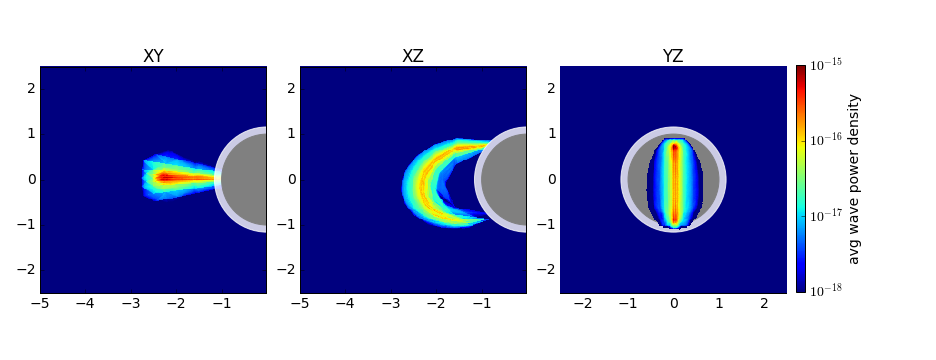

In [544]:
def plot_avg_pwr(data, xlims, ylims, zlims, step_size):
    R_E = 6371e3
    H_IONO = 1000e3

    xx = np.arange(xlims[0], xlims[1], step_size)
    yy = np.arange(ylims[0], ylims[1], step_size)
    zz = np.arange(zlims[0], zlims[1], step_size)

    nx = len(xx) 
    ny = len(yy)
    nz = len(zz)

    xz_sum = np.log10((np.sum(data, axis=1).T)/len(yy))
    xy_sum = np.log10((np.sum(data, axis=2).T)/len(zz))
    yz_sum = np.log10((np.sum(data, axis=0).T)/len(xx))

    maxlog = np.max([np.max(xz_sum), np.max(xy_sum), np.max(yz_sum)])
    
    # Show about 3 orders of magnitude
    clims = [maxlog - 3, maxlog]

    xy_sum[np.isinf(xy_sum)] = -100
    xz_sum[np.isinf(xz_sum)] = -100
#     yz_sum[np.isinf(yz_sum)] = -100
    flatblack = np.ones_like(yz_sum)*-100

    fig, ax = plt.subplots(1,3)
    # Plot the earth
    for i in [0, 1, 2]:
        earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
        iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='w',alpha=0.8, zorder=99)
        ax[i].add_patch(earth)   
        ax[i].add_patch(iono)
    
    p0 = ax[0].pcolorfast(xx, yy, xy_sum, vmin=clims[0], vmax=clims[1])
    p1 = ax[1].pcolorfast(xx, zz, xz_sum, vmin=clims[0], vmax=clims[1])
    p2 = ax[2].pcolorfast(yy, zz, yz_sum, vmin=clims[0], vmax=clims[1], zorder=101)
    p3 = ax[2].pcolorfast(yy, zz, flatblack, vmin=clims[0], vmax=clims[1], zorder=98)

#     divider = make_axes_locatable(ax[2])
#     cax = divider.append_axes("right",size="4%",pad=0.15)
#     cb = plt.colorbar(p2, cax=cax)
#     cb.set_label('avg wave power density')
#     cticks = np.arange(clims[0],clims[1] + 1)
#     cb.set_ticks(cticks)
#     cticklabels = ['$10^{%d}$'%k for k in cticks]
#     cb.set_ticklabels(cticklabels)
    
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    ax[2].set_aspect('equal')

    ax[0].set_title('XY')
    ax[1].set_title('XZ')
    ax[2].set_title('YZ')
    
    ax[0].set_xlim([xx[0],xx[-1]])
    ax[0].set_ylim([yy[0],yy[-1]])
    ax[1].set_xlim([xx[0],xx[-1]])
    ax[1].set_ylim([zz[0],zz[-1]])
    ax[2].set_xlim([yy[0],yy[-1]])
    ax[2].set_ylim([zz[0],zz[-1]])
    
    
    

    
    fig.tight_layout()
    
    
    # cax = fig.colorbar(p, ax=ax.ravel().tolist())
    fig.subplots_adjust(right=0.84)
    cax = fig.add_axes([0.85,0.19, 0.01, 0.629])

    cb = plt.colorbar(p2, cax=cax)
    cb.set_label('avg wave power density')
    cticks = np.arange(clims[0],clims[1] + 1)
    cb.set_ticks(cticks)
    cticklabels = ['$10^{%d}$'%k for k in cticks]
    cb.set_ticklabels(cticklabels)
    
    
plot_avg_pwr(data_total, xlims,ylims,zlims,step_size)


In [538]:
print np.sum(data_total)*pow(R_E*step_size,3)*dt/10.

print np.sum(inp_pwrs)

180.454374811
2854.03412852


<IPython.core.display.Javascript object>


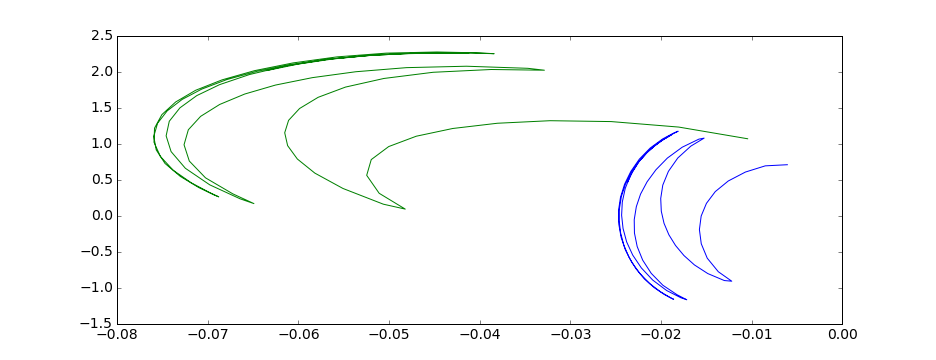

In [209]:
ray_data[ray_data.keys()[0]]
import xflib

def rotate_latlon(raypos, itime, dlat, dlon, xf=None):
    if xf is None:
        xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
        
    newpos = np.zeros_like(raypos)
    for ind in range(np.shape(raypos)[1]):
#         print ind
        tmp = xf.sm2rllmag(raypos[:,ind], itime)
        tmp[1] += dlat
        tmp[2] += dlon
        newpos[:,ind] = xf.rllmag2sm(tmp, itime)
    
    return newpos
        
oldpos = ray_data[ray_data.keys()[0]]['pos']
newpos = rotate_latlon(oldpos,itime, 30, 1)


fig, ax = plt.subplots(1,1)
ax.plot(oldpos[1,:], oldpos[2,:])
ax.plot(newpos[1,:], newpos[2,:])
# ax.set_aspect('equal')


In [225]:
# Volume of voxel:
def voxel_volume(points):
    tri = Delaunay(points.T)
    v = 0
    for row in tri.simplices:
        a = points[:,row[0]]
        b = points[:,row[1]]
        c = points[:,row[2]]
        d = points[:,row[3]]
        
        v += np.abs( np.dot(a - d, np.cross(b-d, c-d)))/6.
    return v
#         print a, b, c, d

voxel_volume(points)

0.00038618675842844738

In [275]:
import igrf12

igrf12

In [528]:
print freqs
print interp_pos.keys()
# print freqs
# for ind, adj_row in enumerate(adj_inds):
#     k0 = pairs_in_range[adj_row[0]]
#     k1 = pairs_in_range[adj_row[1]]
#     k2 = pairs_in_range[adj_row[2]]
#     print interp_pos[k0]
# #     print len(interp_pos[k0]), len(interp_pos[k1]), len(interp_pos[k2])


[200, 230, 270, 320, 370, 440, 510, 600, 700, 820, 960, 1120, 1310, 1530, 1790, 2090, 2450, 2860, 3350, 3920, 4580, 5360, 6270, 7330, 8570, 10030, 11720, 13710, 16040, 18750, 21930, 25650, 30000]
[(47.0, 76.0), (40.0, 78.0), (43.0, 74.0), (39.0, 79.0), (41.0, 79.0), (31.0, 68.0), (35.0, 88.0), (39.0, 70.0), (38.0, 74.0), (35.0, 84.0), (40.0, 74.0), (45.0, 76.0), (43.0, 76.0), (43.0, 88.0), (35.0, 80.0), (41.0, 75.0), (39.0, 74.0), (47.0, 68.0), (37.0, 74.0), (37.0, 76.0), (35.0, 76.0), (41.0, 74.0), (39.0, 78.0), (43.0, 68.0), (38.0, 75.0), (39.0, 72.0), (40.0, 75.0), (40.0, 76.0), (31.0, 80.0), (39.0, 82.0), (43.0, 64.0), (45.0, 78.0), (41.0, 80.0), (40.0, 79.0), (37.0, 78.0), (47.0, 80.0), (31.0, 84.0), (38.0, 76.0), (41.0, 70.0), (35.0, 74.0), (39.0, 73.0), (41.0, 77.0), (39.0, 88.0), (39.0, 64.0), (37.0, 80.0), (42.0, 74.0), (43.0, 72.0), (31.0, 76.0), (39.0, 77.0), (39.0, 92.0), (41.0, 73.0), (42.0, 76.0), (39.0, 68.0), (41.0, 82.0), (39.0, 80.0), (41.0, 78.0), (43.0, 84.0), (40.0

In [566]:
f1=200; f2=230
nf = 1
df = (f2 - f1)

np.arange(0,1,1.0/nf) + (1.0/(2.*nf))


array([ 0.5])